# ATMS 523 - Module 3

## Part 1

Doing the initial setup.

In [56]:
import pandas as pd, numpy as np
from pathlib import Path
import fsspec

S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}

OUTDIR = Path('../data'); OUTDIR.mkdir(parents=True, exist_ok=True)
OUT_PARQUET = OUTDIR / 'ghcn_il_top4_daily.parquet'
OUT_CSV = OUTDIR / 'ghcn_il_top4_daily.csv'
print('Output:', OUT_PARQUET.resolve())

Output: C:\Users\macdonaldc\Documents\ATMS 523\Module 3\data\ghcn_il_top4_daily.parquet


Creating the function.

In [57]:
def GHCN_station_temp_stats(id):
    """
    Returns temperature statistics for a chosen GHCN station ID.

    Calculates the following temperature statistics for the period 1991-2020:
    1. Record high
    2. Record low
    3. Mean high
    4. Mean low

    Returns a dataframe with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp']
    """
    url = f"s3://noaa-ghcn-pds/csv/by_station/{id}.csv"

    # Making the daily dataframe
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    # Quick check
    #print(df[df['ELEMENT']== "TMAX"])
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN'):
        if c in wide: wide[c] = wide[c]/10.0

    # Adds time colums
    wide['year']  = pd.to_datetime(wide['DATE']).dt.year
    wide['month'] = pd.to_datetime(wide['DATE']).dt.month
    wide['day'] = pd.to_datetime(wide['DATE']).dt.day

    # Drops rows with missing temperature data
    wide = wide.dropna(subset=['TMAX', 'TMIN'])

    # Aggregates data with groupby to find record max and min temps
    daily = wide.groupby(['month','day'],as_index=False).agg(TMAX=('TMAX','max'),TMIN=('TMIN','min'))

    # Calculates 1991-2020 normal means
    averages = wide[(wide['year'] >= 1991) & (wide['year'] <= 2020)]

    # Aggregates data with groupby to find average max and min temps
    averages = averages.groupby(['month','day'],as_index=False).agg(TMAX=('TMAX','mean'),TMIN=('TMIN','mean'))

    # Renames columns before merging
    daily = daily.rename(columns={'TMAX': 'record_max_temp', 'TMIN': 'record_min_temp'})
    averages = averages.rename(columns={'TMAX': 'average_max_temp', 'TMIN': 'average_min_temp'})

    # Merges the dataframes
    output = daily.merge(averages)
    # Sort df
    output = output[['month','day','record_min_temp', 'average_min_temp', 'average_max_temp', 'record_max_temp']]

    return output

Finding a station to use.

In [58]:
# Quick check of stations for an ID
colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)]
names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']
stations = pd.read_fwf(S3_STATIONS_TXT, colspecs=colspecs, names=names, dtype={'ID':str,'STATE':str,'WMO_ID':str}, storage_options=STOR)
stations['NAME'] = stations['NAME'].str.strip(); stations['STATE'] = stations['STATE'].fillna('').str.strip()
print(stations.loc[stations['STATE'] == "IL", ['ID', 'NAME']].tail(10))

                 ID                            NAME
128384  USW00054811                  SHABBONA 5 NNE
128386  USW00054831           BLOOMINGTON NORMAL AP
128579  USW00093809                        CAIRO 3N
128580  USW00093810    CARBONDALE STHRN ILLINOIS AP
128589  USW00093822  SPRINGFIELD ABRAHAM LINCOLN CA
128652  USW00093989                  QUINCY RGNL AP
128776  USW00094822        ROCKFORD GTR ROCKFORD AP
128782  USW00094846           CHICAGO OHARE INTL AP
128790  USW00094870     CHAMPAIGN URBANA WILLARD AP
128793  USW00094892     CHICAGO W CHICAGO DUPAGE AP


Doing the test.

In [85]:
# Picking Springfield
id = 'USW00093822'

# Testing function
temps = GHCN_station_temp_stats(id)

print(temp_CoH.head(10))
print(temp_CoH.tail(10))

C:\Users\macdonaldc\AppData\Local\Temp\ipykernel_21432\2854099840.py:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


   month  day  record_min_temp  average_min_temp  average_max_temp  \
0      1    1            -25.0         -7.210000          2.113333   
1      1    2            -24.9         -5.813333          2.926667   
2      1    3            -22.8         -6.150000          2.763333   
3      1    4            -25.6         -6.973333          2.303333   
4      1    5            -29.4         -7.310000          1.683333   
5      1    6            -25.6         -6.843333          1.323333   
6      1    7            -28.3         -7.100000          1.336667   
7      1    8            -23.9         -6.646667          1.953333   
8      1    9            -23.3         -6.520000          2.316667   
9      1   10            -27.8         -5.873333          2.876667   

   record_max_temp  
0             16.1  
1             20.0  
2             19.4  
3             20.0  
4             15.0  
5             20.0  
6             21.1  
7             16.7  
8             15.0  
9             16.1 

Looks like it worked!

## Part 2

In [60]:
import matplotlib.pyplot as plt

Making a modified version of the function in Part 1 to collect the full annual data

In [68]:
def get_actual_temps_for_year(station_id, year):
    """
    Gets the actual daily temperatures for a specific station on a given year.
    
    Takes a station_id and year
    
    Returns a dataframe with columns: month, day, actual_tmax, actual_tmin
    """

    url = f"s3://noaa-ghcn-pds/csv/by_station/{id}.csv"

    # Making the daily dataframe
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    # Quick check
    #print(df[df['ELEMENT']== "TMAX"])
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN'):
        if c in wide: wide[c] = wide[c]/10.0

    # Adds time colums
    wide['year'] = wide['DATE'].dt.year
    wide['month'] = pd.to_datetime(wide['DATE']).dt.month
    wide['day'] = pd.to_datetime(wide['DATE']).dt.day

    wide_year = wide[wide['year'] == year]
    # Drops rows with missing temperature data
    wide_year = wide_year.dropna(subset=['TMAX', 'TMIN'])

    # No aggregation this time
    wide_subset = wide_year[['month','day','TMAX', 'TMIN']]
    annual_values = wide_subset.rename(columns={'TMAX': 'actual_tmax', 'TMIN': 'actual_tmin'}).reset_index(drop=True)

    return annual_values

Testing with a given year.

In [99]:
# Generating actual temperature for the same location in 20220160
id = 'USW00094846'
year = 2016
actual_temps = get_actual_temps_for_year(id, year)
print(actual_temps.head(10))
print(actual_temps.tail(10))


C:\Users\macdonaldc\AppData\Local\Temp\ipykernel_21432\3253935222.py:13: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


ELEMENT  month  day  actual_tmax  actual_tmin
0            1    1         -0.5         -7.1
1            1    2          0.0         -6.6
2            1    3         -1.6         -5.5
3            1    4         -0.5         -5.5
4            1    5          0.6         -8.2
5            1    6          2.2         -6.0
6            1    7          5.0          1.1
7            1    8          5.6          2.2
8            1    9          4.4         -4.9
9            1   10         -4.9        -16.6
ELEMENT  month  day  actual_tmax  actual_tmin
356         12   22          2.8         -4.3
357         12   23          1.7         -2.7
358         12   24          3.3          0.6
359         12   25          3.9          0.0
360         12   26         12.2         -2.1
361         12   27         -2.1         -7.1
362         12   28          7.2         -7.1
363         12   29          1.7         -1.0
364         12   30          3.3         -4.3
365         12   31          4.4  

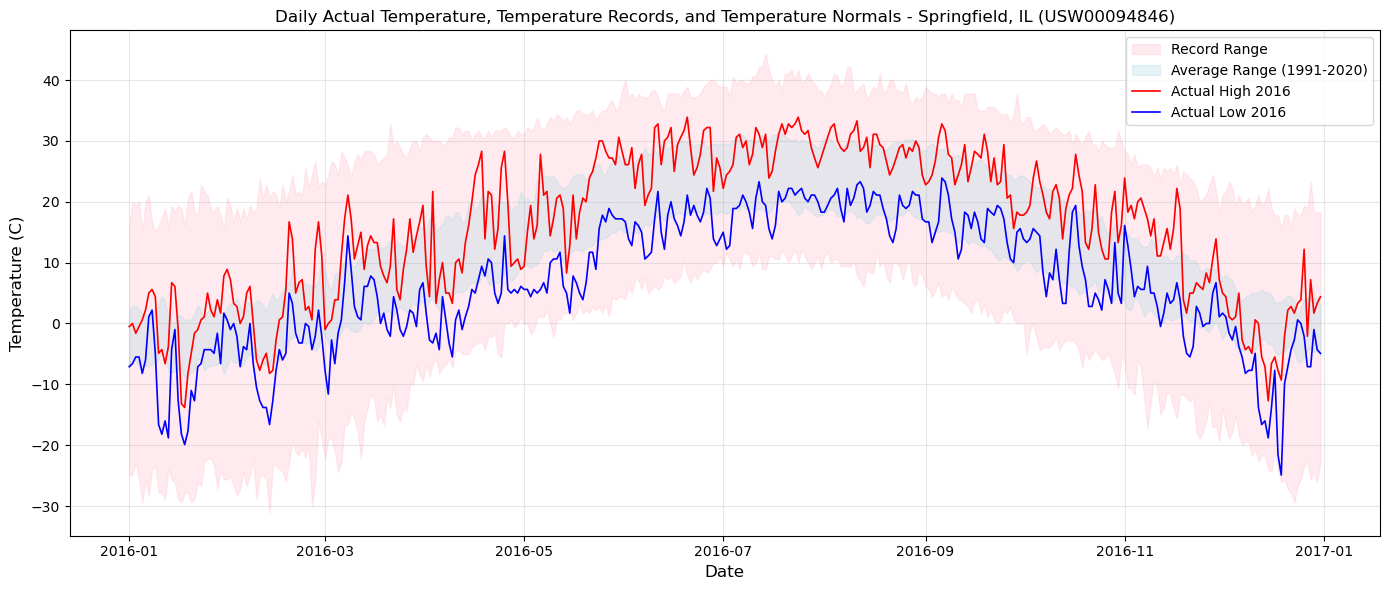

In [101]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create a date index for the x axis
temps['date'] = pd.to_datetime(
    str(year) + '-' + temps['month'].astype(str) + '-' + temps['day'].astype(str),
    errors='coerce'
)

# Merge actual temps to a new df for plotting
temp_plot = temps.merge(actual_temps, on=['month', 'day'], how='left')

# Plot record extremes in a shaded area
ax.fill_between(temp_plot['date'], 
                temp_plot['record_min_temp'], 
                temp_plot['record_max_temp'],
                alpha=0.3, color='pink', label='Record Range')

# Plot average range in a shaded area
ax.fill_between(temp_plot['date'],
                temp_plot['average_min_temp'],
                temp_plot['average_max_temp'],
                alpha=0.3, color='lightblue', label='Average Range (1991-2020)')

# Plot actual temperatures for the year
ax.plot(temp_plot['date'], temp_plot['actual_tmax'], 
        color='red', linewidth=1.2, label=f'Actual High {year}')
ax.plot(temp_plot['date'], temp_plot['actual_tmin'], 
        color='blue', linewidth=1.2, label=f'Actual Low {year}')

# Add axis labels and title and legend
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (C)', fontsize=12)
ax.set_title(f'Daily Actual Temperature, Temperature Records, and Temperature Normals - Springfield, IL ({id})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()